## Анализ полученных данных

Статистика по вакансиям для удобного отображения вынесена в отдельную тетрадку.

In [104]:
#!pip install plotly
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import re

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

from scipy.sparse import hstack
from sklearn.linear_model import Ridge
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

pd.options.mode.chained_assignment = None

sns.set()

### Загрузка данных

In [105]:
df = pd.read_csv('../../hh_results.csv')
df.head()

,Ids,Employer,Name,Salary,From,To,Experience,Schedule,Keys,Description
0,50880086,Домклик,Data analyst/data engineer,False,NaN,NaN,От 1 года до 3 лет,Полный день,"['Python', 'SQL', 'PostgreSQL', 'Базы данных',...",Мы - это продуктовая IT компания по созданию h...
1,50439267,NXP Semiconductors,Data Engineer,False,NaN,NaN,От 1 года до 3 лет,Полный день,"['Python', 'Linux', 'English', 'TCL', 'Data En...",NXP Semiconductors N.V. (NASDAQ: NXPI) enables...
2,51056512,ПИК-БРОКЕР,Data Engineer,True,150000.0,250000.0,От 1 года до 3 лет,Полный день,"['Python', 'SQL', 'PostgreSQL', 'Git', 'Airflow']",Мы - ПИК-Брокер - молодая и очень динамично ра...
3,50657338,COMTEK Inc.,Data Scientist,False,NaN,NaN,От 3 до 6 лет,Полный день,"['Python', 'SQL', 'Power BI', 'Английский язык...",Подбираем команду для крупной американской ком...
4,50439196,Медиа Бизнес Солюшенс,Data scientist,False,NaN,NaN,От 1 года до 3 лет,Полный день,"['Python', 'PostgreSQL', 'Tensorflow', 'sklear...","М3 — компания, которая занимается развитием ци..."


### Количество вакансий

In [106]:
df['Name'] = df.Name.str.lower()

In [107]:
df['Name'] = df.Name.apply(lambda x:'data engineer' if 'data engineer' in x else x)

In [108]:
df['Name'] = df.Name.apply(lambda x:'data scientist' if 'data scientist' in x else x)

In [109]:
for i in ('product analyst', 'аналитик данных', 'продуктовый аналитик', 'data analyst'):
    df['Name'] = df.Name.apply(lambda x:'data analyst' if i in x else x)

In [110]:
da_de_ds = df[
              (df.Name.str.contains('data engineer')) | \
              (df.Name.str.contains('data analyst')) | \
              (df.Name.str.contains('data scientist'))  
             ]

In [111]:
da_de_ds.Name.value_counts()

data engineer     303
data scientist    235
data analyst      231
Name: Name, dtype: int64

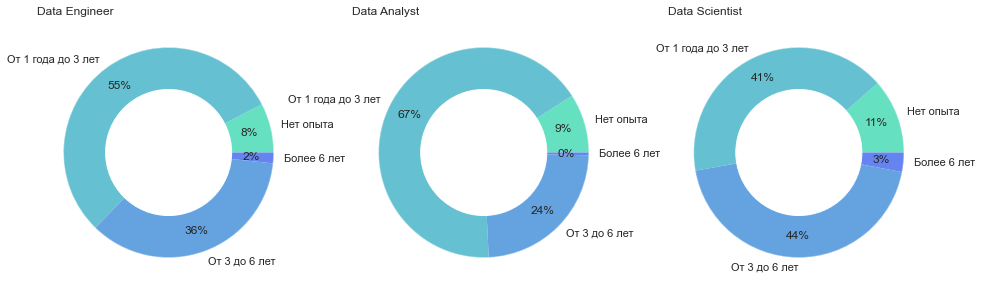

In [112]:
def get_level_stats(data, category):
    level_stats ={
        'Нет опыта': df[(df.Name.str.contains(category)) & (df.Experience == 'Нет опыта')].Ids.count(),
        'От 1 года до 3 лет': df[(df.Name.str.contains(category)) & (df.Experience == 'От 1 года до 3 лет')].Ids.count(),
        'От 3 до 6 лет': df[(df.Name.str.contains(category)) & (df.Experience == 'От 3 до 6 лет')].Ids.count(),
        'Более 6 лет': df[(df.Name.str.contains(category)) & (df.Experience == 'Более 6 лет')].Ids.count(),
    }
    return level_stats
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 10))

centre_circle = plt.Circle((0,0),0.6, fc='white')
centre_circle1 = plt.Circle((0,0),1, fc='white', alpha= 0.4)
level_stats = get_level_stats(df, 'data engineer')
ax1.pie(level_stats.values(), labels=level_stats.keys(), pctdistance=0.79,
        colors=sns.color_palette('winter_r', 4), autopct='%1.f%%', wedgeprops = {'linewidth': 0})
ax1.add_artist(centre_circle)
ax1.add_artist(centre_circle1)
ax1.set_title('Data Engineer', size=12, loc='left')

centre_circle = plt.Circle((0,0),0.6, fc='white')
centre_circle1 = plt.Circle((0,0),1, fc='white', alpha= 0.4)
level_stats = get_level_stats(df, 'data analyst')
ax2.pie(level_stats.values(), labels=level_stats.keys(), pctdistance=0.79,
        colors=sns.color_palette('winter_r', 4), autopct='%1.f%%', wedgeprops = {'linewidth': 0})
ax2.add_artist(centre_circle)
ax2.add_artist(centre_circle1)
ax2.set_title('Data Analyst', size=12, loc='left')


centre_circle = plt.Circle((0,0),0.6, fc='white')
centre_circle1 = plt.Circle((0,0),1, fc='white', alpha= 0.4)
level_stats = get_level_stats(df, 'data scientist')
ax3.pie(level_stats.values(), labels=level_stats.keys(), pctdistance=0.79,
        colors=sns.color_palette('winter_r', 4), autopct='%1.f%%', wedgeprops = {'linewidth': 0})
ax3.add_artist(centre_circle)
ax3.add_artist(centre_circle1)
ax3.set_title('Data Scientist', size=12, loc='left')
plt.show()

### Зарплаты в Data Science

In [113]:
salary = da_de_ds[(da_de_ds.From.notnull()) | (da_de_ds.To.notnull())]

In [114]:
salary = salary[salary['Experience'] != 'Более 6 лет'].sort_values(by='Experience')

In [115]:
salary['mean_salary'] = salary[['From', 'To']].mean(axis=1)

In [116]:
salary['Keys'] = salary.Keys.str.lower()

In [117]:
dis = salary[['Name', 'Experience']].append(salary[['Name', 'Experience']])
dis['Salary'] = salary[['From', 'To']].melt()['value'].tolist()

In [118]:
fig = px.box(dis, x="Experience", y="Salary", color='Name', labels={
             "Salary": "Уровень зарплат в тыс. рублях",
             "Experience": "Уровень",
             "Name": "Специальность"
         }, title = 'Распределение зарплат по грейдам')
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,)
fig.show()

### Анализ востребованности навыков

In [119]:
skills = {
    'TensorFlow': {'tensorflow', '\Wtf\W', 'тензорфлоу'},
    'PyTorch': {'pytorch', 'пайторч'},
    'Keras': {'keras', 'керас'},
    'Python': {'python', 'питон', 'пайтон'},
    'Pandas/numpy': {'\Wpandas\W', '\Wnumpy\W'},
    'R': {'\Wr\W'},
    'SQL': {'sql', 'ms sql'},
    'Scala': {'scala', 'скала'},
    'Java': {'java', 'джава'},
    'Julia': {'julia', 'джули[ая]'},
    'Go': {'\Wgo\W'},
    'C++': {'c\+\+'},
    'C#': {'c#', 'шарп'},
    'Linux': {'bash', 'баш', 'linux', 'линукс'},
    'JS': {'\Wjs\W', 'java\W?script'},
    'Matlab': {'matlab', 'матлаб'},
    'Django': {'django', 'джанго'},
    'Flutter': {'flutter', 'флатт?ер'},
    'Flask': {'flask', 'фласк'},
    'Spring': {'spring'},
    'Git': {'git', 'github', 'bitbucket', 'gitlab', 'гит', 'гитхаб', 'битбакет', 'гитлаб'},
    'Docker': {'docker', 'докер'},
    'Kubernetes': {'kubernetes', 'кубернетес'},
    'Openshift': {'openshift'},
    'Grafana': {'grafana', 'графан'},
    'Power BI': {'power bi', 'powerbi'},
    'Tableau': {'tableau', 'табло'},
    'Airflow': {'airflow', 'а[э]ирфлоу'},
    'Prometheus': {'prometheus', 'прометеус'},
    'Redshift': {'redshift'},
    'HDFS': {'hdfs'},
    'MapReduce': {'mapreduce'},
    'Spark': {'spark', 'спарк'},
    'Hive': {'hive'},
    'Azure': {'azure'},
    'Hadoop': {'hadoop', 'хадуп'},
    'Kafka': {'kafka', 'кафк[ау]'},
    'RabbitMQ': {'rabbit', 'кролик'},
    'MongoDB': {'mongo.?db'},
    'Firebase': {'firebase'},
    'Cassandra': {'cassandra'},
    'Redis': {'redis'},
    'Redshift': {'redshift'},
    'BigQuery': {'bigquery'},
    'Excel': {'\Wexcel\W', '\Wэксел\W'},
    'Clickhouse': {'clickhouse', 'кликхау[сз]'},
    'XGBoost': {'xgboost', '\Wxgb\W'},
    'LightGBM': {'lightgbm', '\Wlgb\W'},
    'CatBoost': {'catboost'},
    'Scikit-learn': {'scikit', 'sklearn'},
    'SciPy': {'scipy'},
    'MLflow': {'mlflow', 'ml flow'},
    'Agile': {'\Wagile\W'},
    'BI': {'\Wbusiness\W', 'bi'},
    'English': {'\Wenglish\W'},
}

In [120]:
def get_keyword_df(df, keywords):
    for keyword, keywords_to_search in keywords.items():
        keywords_regex = '|'.join(keywords_to_search)
        df[keyword] = df['Keys'].str.contains(keywords_regex, regex=True)
    keywords_df = pd.DataFrame(columns=['keyword', 'number'])
    for keyword in list(keywords.keys()):
        keywords_df = keywords_df.append({'keyword': keyword, 'number': len(df[df[keyword]])}, ignore_index=True)
    keywords_df = keywords_df.sort_values(by=['number'], ascending=False).reset_index(drop=True)
    keywords_df['perc'] = keywords_df['number'] / len(df) * 100
    return keywords_df

In [121]:
da_de_ds.Name.unique()

array(['data engineer', 'data scientist', 'data analyst'], dtype=object)

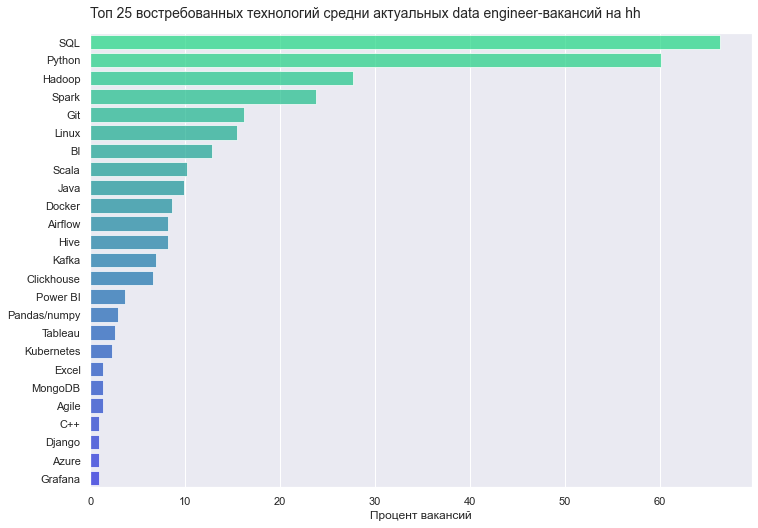

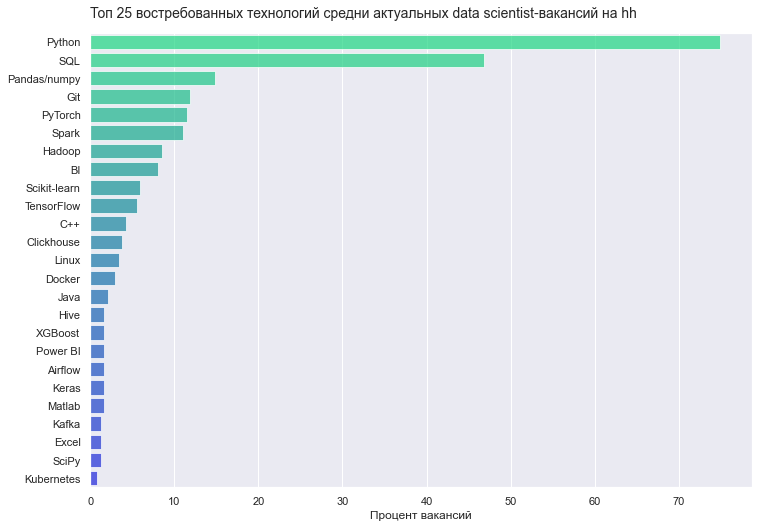

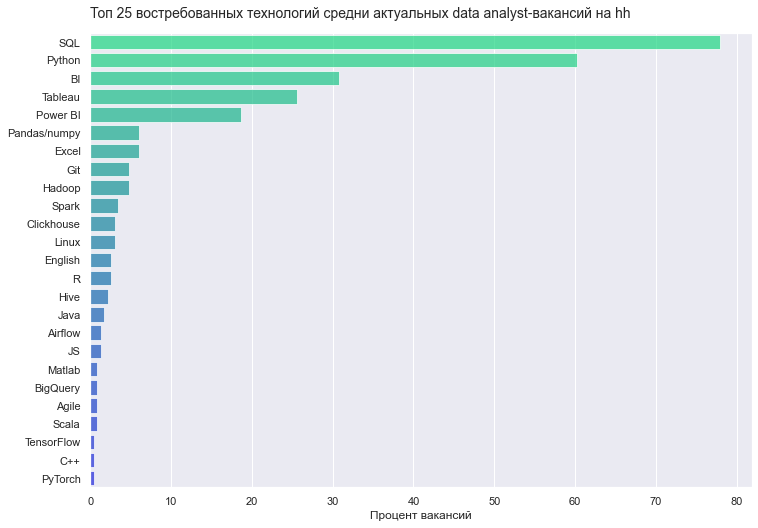

In [122]:
for name in da_de_ds.Name.unique():
    da_de_ds['Keys'] = da_de_ds.Keys.str.lower()
    keyword_df = get_keyword_df(da_de_ds[da_de_ds['Name'] == name], skills).head(25)
    skills_list = [i for i in keyword_df['keyword'].values]

    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    fig.tight_layout(w_pad=5)

    sns.barplot(ax = ax, data=keyword_df, x='perc', y='keyword', palette=sns.color_palette('winter_r', 25), alpha=0.7)
    ax.set_title(label=f'Топ 25 востребованных технологий средни актуальных {name}-вакансий на hh', loc='left', size=14, pad=15)
    ax.set_xlabel('Процент вакансий')
    ax.set_ylabel('')

### Предсказание зарплаты

На этом этапе происходит предсказание зарплаты для вакансий, у которых она не указана. Ниже пошагово представлен алгоритм.
___

**Шаг 1: Предобработка данных**:
- Удаление NaN значений из таблицы,
- Поиск среднего значение для From / To столбцов,
- Замена столбцов зарплаты на усредненое значение

In [123]:
# Replace NaN from Salary into From / To fields,
# Find mean values for each elemen and drop NaNs
df = pd.read_csv('hh_results.csv')
df_num = df[df['From'].notna() | df['From'].notna()]
df_avg = df_num[['From', 'To']].mean(axis=1)
df_num = df_num.drop(['Salary', 'From', 'To'], axis=1)
df_num.insert(3, 'Average', df_avg)

**Шаг 2: Подготовка модели**:
- Формирование вектора признаков из столбца ключевых навыков со списком исключений `stop_words`
- Поиск наиболее часто используемых слов в ключевых навыках
- One-Hot кодирование признаков таблицы
- Объединение в матрицу "объекты-признаки"

In [124]:
def text_replace(text) -> pd.Series:
    return text.str.lower().replace("[^a-zA-Z]\bqout\b|\bamp\b", " ", regex=True)

# Set TF-IDF features
min_df = 5 # ignore terms w/ frequency < than threshold
tf_idf = TfidfVectorizer(min_df=min_df, stop_words='english')

# Training set
X_train_text = tf_idf.fit_transform(text_replace(df_num['Keys']))
# Dict: {key: counter}
# print(pd.Series(tf_idf.vocabulary_)[:10])

# Print top words used in keys
idx = np.ravel(X_train_text.sum(axis=0).argsort(axis=1))[::-1][:7]
top_words = np.array(tf_idf.get_feature_names())[idx].tolist()
print('Top words used in keys: {}'. format(top_words))

# One-hot-encoding for data frame features
dct_enc = DictVectorizer()
X_train_cat = dct_enc.fit_transform(df_num[['Experience', 'Name']].to_dict('Records'))

# Stack vectors
X_train = hstack([X_train_text, X_train_cat])

Top words used in keys: ['python', 'sql', 'data', 'язык', 'английский', 'анализ', 'analysis']


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



**Шаг 3: Обучение модели**

In [125]:
# Train model
y_train = df_num['Average']
model = Ridge(alpha=1, random_state=255)
model.fit(X_train, y_train)

Ridge(alpha=1, random_state=255)

**Шаг 4: Применение к тестовым данным**

In [126]:
# Frame with NaNs
x_test = df[df['From'].isna() & df['To'].isna()]

# Test vectors
X_test_text = tf_idf.transform(text_replace(x_test['Description']))
X_test_cat = dct_enc.transform(x_test[['Experience', 'Name']].to_dict('Records'))
X_test = hstack([X_test_text, X_test_cat])

# Prediction model - result
y_test = model.predict(X_test)

print('Average salary for vacancies with NaN is {}'.format(y_test.mean(dtype=int)))

Average salary for vacancies with NaN is 191835


**Шаг 5: Замена отсутствующих зарплат на предсказанные значения**

In [127]:
df_tst = x_test.drop(['Salary', 'From', 'To'], axis=1)
df_tst.insert(3, 'Average', y_test.astype(int))
df_tst.head(10)

,Ids,Employer,Name,Average,Experience,Schedule,Keys,Description
0,50880086,Домклик,Data analyst/data engineer,145430,От 1 года до 3 лет,Полный день,"['Python', 'SQL', 'PostgreSQL', 'Базы данных',...",Мы - это продуктовая IT компания по созданию h...
1,50439267,NXP Semiconductors,Data Engineer,177103,От 1 года до 3 лет,Полный день,"['Python', 'Linux', 'English', 'TCL', 'Data En...",NXP Semiconductors N.V. (NASDAQ: NXPI) enables...
3,50657338,COMTEK Inc.,Data Scientist,175599,От 3 до 6 лет,Полный день,"['Python', 'SQL', 'Power BI', 'Английский язык...",Подбираем команду для крупной американской ком...
4,50439196,Медиа Бизнес Солюшенс,Data scientist,163075,От 1 года до 3 лет,Полный день,"['Python', 'PostgreSQL', 'Tensorflow', 'sklear...","М3 — компания, которая занимается развитием ци..."
5,48301399,Wargaming,ML/RL Engineer,431138,Более 6 лет,Полный день,[],Wargaming is looking for ML/RL Engineer. You w...
7,50749704,Билайн,Стажер Data Scientist,149694,Нет опыта,Полный день,"['Аналитическое мышление', 'Работа с большим о...",«Билайн» сейчас – компания изменений. В 2020 м...
8,50855401,Московская школа управления СКОЛКОВО,Data engineer,201304,От 3 до 6 лет,Полный день,"['Python', 'SQL', 'Linux', 'AllFusion ERwin Da...",Московская школа управления СКОЛКОВО открывает...
11,49031421,inDriver,Senior Data Engineer,162224,Нет опыта,Полный день,"['Python', 'SQL', 'Spark']",inDriver — международный сервис пассажирских п...
12,50751593,Моринтех,Разработчик нейросетевых алгоритмов / Data sci...,126912,От 1 года до 3 лет,Полный день,"['Python', 'SQL', 'AllFusion ERwin Data Modele...",Команда ООО &quot;Моринтех&quot; старается пол...
13,50580531,SberAutoTech,MLOps Engineer (Data Factory),247204,От 3 до 6 лет,Полный день,"['Linux', 'Python', 'Обучение и развитие', 'Ор...","У команды SberAutoTech есть цель, и это – рево..."


C:\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

58.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



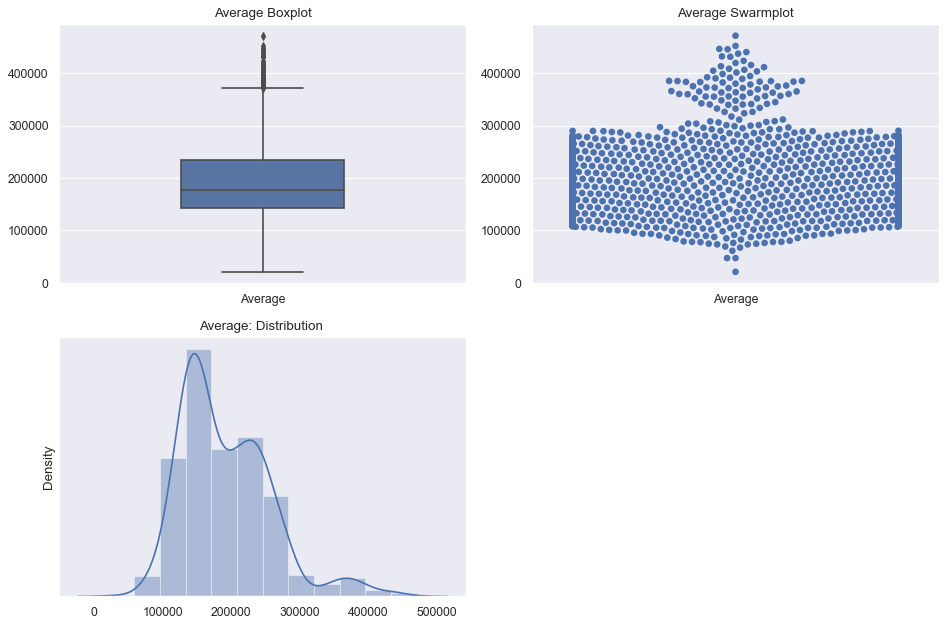

In [128]:
fp = plt.figure('Predicted salaries', figsize=(12, 8), dpi=80)
fp.add_subplot(2, 2, 1)
plt.title('Average Boxplot')
sns.boxplot(data=df_tst[['Average']], width=0.4)

fp.add_subplot(2, 2, 2)
plt.title('Average Swarmplot')
sns.swarmplot(data=df_tst[['Average']].dropna(), size=6)

fp.add_subplot(2, 2, 3)
plt.title('Average: Distribution ')
sns.distplot(df_tst[['Average']].dropna(), bins=12)
plt.grid(False)
plt.yticks([], [])
plt.tight_layout()